In [2]:
%matplotlib nbagg
import math
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import integrate
import matplotlib.pyplot as plt

import pickle

from actuated_Koopman_EM_4 import ActuatedKoopmanEM, save_EM_model, load_EM_model

# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.unicode'] = True

# Generate Data from Toy Dynamical System

\begin{equation}
\begin{split}
    \dot{x}_1 &= -\alpha x_1 + u \\
    \dot{x}_2 &= \beta\left( x_1^3 - x_2 \right) \\
    y &= x_2
\end{split}
\end{equation}

\begin{equation}
    \frac{d}{dt}\begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1^3 \end{bmatrix} = 
    \begin{bmatrix} 
        0 & 0 & 0 & 0 & 0 \\
        0 & -\alpha & 0 & 0 & 0 \\
        0 & 0 & -\beta & 0 & \beta \\
        0 & 0 & 0 & -2\alpha & 0 \\
        0 & 0 & 0 & 0 & -3\alpha 
    \end{bmatrix}
    \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1^3 \end{bmatrix}
    + u \begin{bmatrix} 
        0 & 0 & 0 & 0 & 0 \\
        1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 \\
        0 & 2 & 0 & 0 & 0 \\
        0 & 0 & 0 & 3 & 0
    \end{bmatrix}
    \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1^3 \end{bmatrix}
\end{equation}

## Define the ground truth model

In [3]:
# state dimension
n = 2

# parameters
alpha = 1.0
beta = 5.0

sig_u = 5.0

sig_noise = 0.01

# time step
dt = 0.01

V0_gt = np.array([[0, 0, 0, 0, 0],
                  [0, -alpha, 0, 0, 0],
                  [0, 0, -beta, 0, beta],
                  [0, 0, 0, -2*alpha, 0],
                  [0, 0, 0, 0, -3*alpha]])
V1_gt = np.array([[0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 2, 0, 0, 0],
                  [0, 0, 0, 3, 0]])

f = lambda x, t: [-alpha*x[0]+u, beta*(np.power(x[0],3) - x[1])]

## Generate data

In [ ]:
n_traj = 50
n_t_interval = 50
n_u_interval = 10
n_t = n_u_interval*n_t_interval + 1

Y_data = np.zeros((n_traj, n_t, 1))
U_data = np.zeros((n_traj, n_t-1, 2))
for j in range(n_traj):
    k = 0
    x = np.random.randn(n)
    Y_data[j,k,0] = x[1] + np.sqrt(sig_noise)*np.random.randn()
    for ku in range(n_u_interval):
        u = np.sqrt(sig_u)*np.random.randn()
        sol = sp.integrate.odeint(lambda x, t: [-alpha*x[0]+u, beta*(np.power(x[0],3) - x[1])], 
                                  x, dt*np.arange(0,n_t_interval+1))
        for kt in range(n_t_interval):
            U_data[j,k,0] = 1
            U_data[j,k,1] = u
            k = k + 1
            x = sol[kt+1,:]
            Y_data[j,k,0] = x[1] + np.sqrt(sig_noise)*np.random.randn()

# use the first n_t_train points from each trajectory for training
n_t_train = 250
Y_train = np.ascontiguousarray(Y_data[:,:n_t_train,:])
U_train = np.ascontiguousarray(U_data[:,:n_t_train-1,:])

## Save the data

In [17]:
fname = 'models/toy_model_sweep/data_tmp.p'

data = {'Y_data': Y_data, \
        'U_data': U_data, \
        'n_traj': n_traj, \
        'n_t': n_t, \
        'dt': dt, \
        'Y_train': Y_train, \
        'U_train': U_train, \
        'n_t_train': n_t_train}

with open( fname, "wb" ) as f:
    pickle.dump(data, f)

## Load data

In [4]:
fname = 'models/toy_model_sweep/data.p'

with open(fname,'rb') as f:
    data = pickle.load(f)

Y_data = data['Y_data']
U_data = data['U_data']
n_traj = data['n_traj']
n_t = data['n_t']
dt = data['dt']

Y_train = data['Y_train']
U_train = data['U_train']
n_t_train = data['n_t_train']

y_dim = Y_data.shape[2]
u_dim = U_data.shape[2]

## Plot a trajectory

<IPython.core.display.Javascript object>


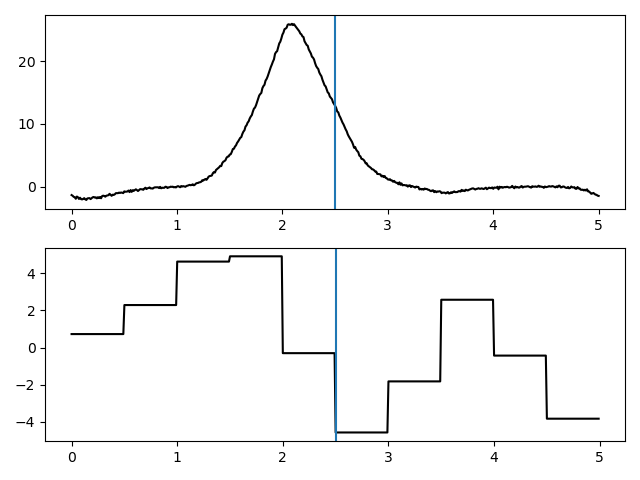

In [5]:
j = np.random.randint(n_traj)

fig, axs = plt.subplots(2)
# plot predicted data
axs[0].plot(np.arange(n_t)*dt, Y_data[j,:,0], 'k-')
axs[0].axvline(x=n_t_train*dt, ymin=0, ymax=1)

axs[1].plot(np.arange(n_t-1)*dt, U_data[j,:,1], 'k-')
axs[1].axvline(x=n_t_train*dt, ymin=0, ymax=1)

fig.tight_layout()

plt.show()

# Train Models with Random Initialization

## Girko circular law

In [6]:
def reflect_eigs(A):
    # relect eigenvalues with magnitude >1 into the unit circle
    lam, Vl, Vr = sp.linalg.eig(A, left=True, right=True)
    w = np.diag(np.dot(np.conj(Vr).T, Vl))
    Vl = Vl/w
    mask = np.absolute(lam) > 1
    lam[mask] = 1.0/lam[mask]
    A_new = np.real(np.dot(Vr*lam, np.conj(Vl).T))
    return A_new

<IPython.core.display.Javascript object>


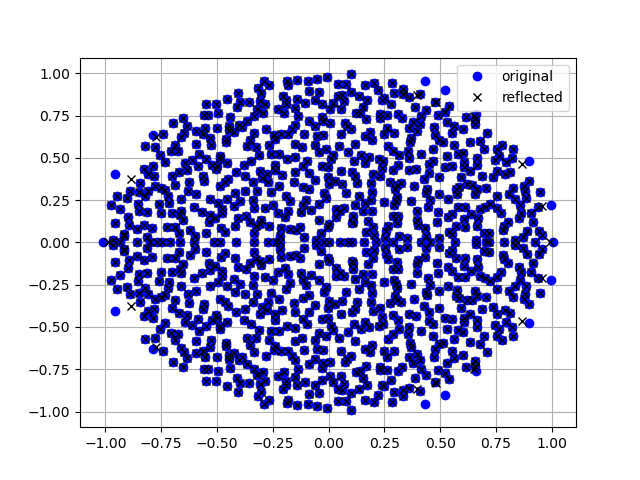

In [7]:
# Girko circular law

d = 1000
A = np.random.randn(d,d)/np.sqrt(d)
A_ref = reflect_eigs(A)
lam = np.linalg.eigvals(A)
lam_ref = np.linalg.eigvals(A_ref)

plt.figure()
plt.plot(np.real(lam), np.imag(lam),'bo', label='original')
plt.plot(np.real(lam_ref), np.imag(lam_ref),'kx', label='reflected')
plt.legend()
plt.grid()

plt.show()

## Initialize random models

In [8]:
# dimensions of models
model_dims = [3, 4, 5, 6]

# number of randomly initialized models at each dimension
n_models = 5

for z_dim in model_dims:
    for mdl_idx in range(n_models):
        cond = True
        while cond:
            try:
                ## initialization for generators
                A0 = reflect_eigs(np.random.randn(z_dim-1,z_dim-1)/np.sqrt(z_dim-1))
                A1 = reflect_eigs(np.random.randn(z_dim,z_dim)/np.sqrt(z_dim))
                
                V_matrices = np.zeros((u_dim,z_dim,z_dim))
                V_matrices[0,1:,1:] = 0.5 * (A0 - np.eye(z_dim-1))/dt
                V_matrices[1,1:,:] = 0.5 * A1[1:,:] / (dt * np.max(np.absolute(U_train[:,:,1])) )
                
                # initialize process noise covariance
                Sig_v = 1.0e-1*np.eye(z_dim-1)
                
                # observation matrix (fixed)
                C = np.zeros((y_dim,z_dim-1))
                C[0,0] = 1.0
                
                # observation offset
                h = np.zeros((y_dim))
                
                # initialize observation noise covariance
                Sig_w = 1.0e-1*np.eye(y_dim)
                
                # initialize initial state mean
                mu_0 = np.zeros(z_dim-1)
                
                # initialize initial state covariance
                Sig_0 = np.eye(z_dim-1)
                
                ## initialize an EM model
                print('initializing model {:d} of {:d} with dimension {:d}\n'.format(mdl_idx+1, n_models, z_dim))
                EM_model = ActuatedKoopmanEM(Y_train, dt*U_train, \
                                             V_matrices, C, h, Sig_v, Sig_w, mu_0, Sig_0, \
                                             compute_log_likelihood=True)
                
                ## save the model
                fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}'.format(z_dim, mdl_idx)
                save_EM_model(EM_model, fname, Y_train, dt*U_train)
                
                cond = False
            except:
                cond = True

initializing model 1 of 5 with dimension 3

	 inferring latent states...



C:\Users\Sam Otto\Desktop\Research\ActuatedKoopmanModelsFromIncompleteObservations_2020\Python_code\actuated_Koopman_EM_4.py:568: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  muhat_k_k, Sighat_k_k, Sighat_k_km1 = _Kalman_update(\
C:\Users\Sam Otto\Desktop\Research\ActuatedKoopmanModelsFromIncompleteObservations_2020\Python_code\actuated_Koopman_EM_4.py:568: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  muhat_k_k, Sighat_k_k, Sighat_k_km1 = _Kalman_update(\
C:\Users\Sam Otto\Desktop\Research\ActuatedKoopmanModelsFromIncompleteObservations_2020\Python_code\actuated_Koopman_EM_4.py:568: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  muhat_k_k, Sighat_k_k, Sighat_k_km1 = _Kalman_update(\
C:\Users\Sam Otto\Desktop\Research\ActuatedKoopmanModelsFromIncomplete


 iter 0 log likelihood = -6.211310e+04

initializing model 2 of 5 with dimension 3

	 inferring latent states...


 iter 0 log likelihood = -1.346459e+05

initializing model 3 of 5 with dimension 3

	 inferring latent states...


 iter 0 log likelihood = -1.338109e+05

initializing model 4 of 5 with dimension 3

	 inferring latent states...


 iter 0 log likelihood = -5.035020e+04

initializing model 5 of 5 with dimension 3

	 inferring latent states...


 iter 0 log likelihood = -2.275912e+05

initializing model 1 of 5 with dimension 4

	 inferring latent states...

initializing model 1 of 5 with dimension 4

	 inferring latent states...


 iter 0 log likelihood = -1.207177e+05

initializing model 2 of 5 with dimension 4

	 inferring latent states...


 iter 0 log likelihood = -1.168075e+05

initializing model 3 of 5 with dimension 4

	 inferring latent states...


 iter 0 log likelihood = -4.896953e+04

initializing model 4 of 5 with dimension 4

	 inferring latent states...


 iter

## Run a fixed number of EM steps on each model

In [10]:
# number of EM steps to run on each model
n_EM_steps = 100

# number of steps between log likelihood calculations
n_skip_L_calc = 10

for z_dim in model_dims:
    for mdl_idx in range(n_models):
        ## Load the model
        fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}'.format(z_dim, mdl_idx)
        EM_model = ActuatedKoopmanEM()
        EM_model, _, _ = load_EM_model(EM_model, fname)
        
        # log likelihood of the model
        L = EM_model.L
        delta_L = np.inf
        
        ## if the desired number of steps have not been run, 
        # run the optimization
        while EM_model.EM_iter < n_EM_steps and delta_L > 0:
            print('training model {:d} of {:d} with dimension {:d}\n'.format(mdl_idx+1, n_models, z_dim))
            if EM_model.EM_iter%n_skip_L_calc == 0 and EM_model.EM_iter > 0:
                # run EM step and compute log likelihood
                EM_model.run_EM_step(explicit_time_step = True, optimize_IC=True, \
                                     optimize_observation_map=False, optimize_process_noise=True, \
                                     compute_log_likelihood=True)
                
                # average change in log likelihood
                delta_L = (EM_model.L - L)/n_skip_L_calc
                print('delta_L = {:3e}\n'.format(delta_L))
                
                # update the log likelihood
                L = EM_model.L
                
                ## Save the model
                if delta_L > 0:
                    save_EM_model(EM_model, fname, Y_train, dt*U_train)
            else:
                ## run an EM step without computing log likelihood
                EM_model.run_EM_step(explicit_time_step = True, optimize_IC=True, \
                                     optimize_observation_map=False, optimize_process_noise=True, \
                                     compute_log_likelihood=False)
                
                ## Save the model
                # save_EM_model(EM_model, fname, Y_train, dt*U_train)

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

training model 5 of 5 with dimension 3

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 3

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 3

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 3

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 3

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 31 log likelihood = 8.103218e+03

delta_L = 7.040791e+01

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 81 log likelihood = 8.564620e+03

delta_L = 1.732132e+00

training model 1 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 21 log likelihood = 7.879916e+03

delta_L = 1.043443e+02

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 71 log likelihood = 8.886626e+03

delta_L = 1.489268e+01

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 11 log likelihood = 7.323403e+03

delta_L = 1.877880e+03

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 61 log likelihood = 8.621919e+03

delta_L = 9.204738e+00

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 4

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 51 log likelihood = 8.883895e+03

delta_L = 1.732162e+01

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 41 log likelihood = 8.381881e+03

delta_L = 2.131880e+01

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 91 log likelihood = 8.599364e+03

delta_L = 3.131234e+00

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 5

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 31 log likelihood = 8.537397e+03

delta_L = 2.322642e+01

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 81 log likelihood = 9.148392e+03

delta_L = 5.679851e+00

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 1 of 5 with dimension 

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 2 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 21 log likelihood = 8.226890e+03

delta_L = 7.562133e+01

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 71 log likelihood = 9.014586e+03

delta_L = 1.246439e+01

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 3 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 21 log likelihood = 8.233507e+03

delta_L = 6.639241e+01

training model 4 of 5 with dimension 

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 4 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 11 log likelihood = 7.409648e+03

delta_L = 7.668177e+03

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical paramete

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 61 log likelihood = 8.801424e+03

delta_L = 1.718774e+01

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 6

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

training model 5 of 5 with dimension 

## Train best model at each dimension until convergence

In [45]:
# Log likelihood of each model
L_models = np.zeros((len(model_dims), n_models))

for i in range(len(model_dims)):
    z_dim = model_dims[i]
    for mdl_idx in range(n_models):
        ## Load the model
        fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}_iter{:d}'.format(z_dim, mdl_idx, 100)
        # fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}'.format(z_dim, mdl_idx)
        EM_model = ActuatedKoopmanEM()
        EM_model, _, _ = load_EM_model(EM_model, fname)
        
        # log likelihood of the model
        L_models[i, mdl_idx] = EM_model.L
        
#         fname_new = 'models/toy_model_sweep/model_dim{:d}_no{:d}_iter{:d}'.format(z_dim, mdl_idx, EM_model.EM_iter)
#         save_EM_model(EM_model, fname_new, Y_train, dt*U_train)

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...

	 inferring latent states...



[[6922.01069058 6539.34598783 7695.93615882 6818.61835824 6819.43487031]
 [8580.96657918 8604.5969201  9069.08188669 8765.6543406  9028.126277  ]
 [8720.94668127 9184.89796614 9182.21043806 8599.36397557 9170.65223151]
 [9191.9312664  9126.38766271 9151.50336018 9145.09374818 9113.42935433]]


<IPython.core.display.Javascript object>


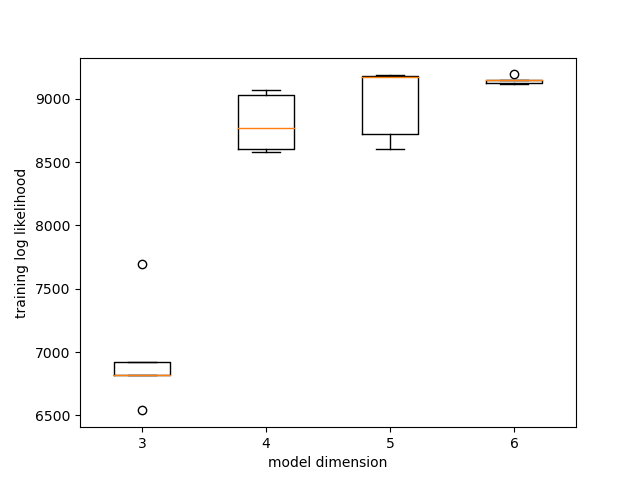

In [46]:
print(L_models)
best_mdl_idcs = np.argmax(L_models, axis=1)

plt.figure()
plt.boxplot(L_models.T, labels=model_dims)
plt.xlabel('model dimension')
plt.ylabel('training log likelihood')
plt.show()

In [55]:
delta_L_tol = 1.0e-2

# number of steps between log likelihood calculations
n_skip_L_calc = 10

for dim_idx in range(len(model_dims)):
    z_dim = model_dims[dim_idx]
    mdl_idx = best_mdl_idcs[dim_idx]
    
    ## Load the model
    fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}'.format(z_dim, mdl_idx)
    EM_model = ActuatedKoopmanEM()
    EM_model, _, _ = load_EM_model(EM_model, fname)
    
    # log likelihood of the model
    L = EM_model.L
    delta_L = np.inf
    
    ## if the log likelihood has not converged continue running, 
    # run the optimization
    while delta_L > delta_L_tol:
        print('dimension {:d} iteration {:d} \n'.format(z_dim, EM_model.EM_iter+1))
        if EM_model.EM_iter%n_skip_L_calc == 0 and EM_model.EM_iter > 0:
            # run EM step and compute log likelihood
            EM_model.run_EM_step(explicit_time_step = True, optimize_IC=True, \
                                 optimize_observation_map=False, optimize_process_noise=True, \
                                 compute_log_likelihood=True)
            
            # average change in log likelihood
            delta_L = (EM_model.L - L)/n_skip_L_calc
            print('delta_L = {:3e}\n'.format(delta_L))
            
            # update the log likelihood
            L = EM_model.L
            
            ## Save the model
            if delta_L > 0:
                save_EM_model(EM_model, fname, Y_train, dt*U_train)
        else:
            ## run an EM step without computing log likelihood
            EM_model.run_EM_step(explicit_time_step = True, optimize_IC=True, \
                                 optimize_observation_map=False, optimize_process_noise=True, \
                                 compute_log_likelihood=False)
            
            ## Save the model
            # save_EM_model(EM_model, fname, Y_train, dt*U_train)

	 inferring latent states...

dimension 3 iteration 101 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 101 log likelihood = 7.696249e+03

delta_L = 3.128728e-02

dimension 3 iteration 102 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 3 iteration 103 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 3 iteration 104 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 3 iteration 105 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 3 iteration 106 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 in

dimension 4 iteration 140 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 141 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 141 log likelihood = 9.226539e+03

delta_L = 1.691160e+00

dimension 4 iteration 142 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 143 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 144 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 145 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dime

dimension 4 iteration 191 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 191 log likelihood = 9.269821e+03

delta_L = 4.957855e-01

dimension 4 iteration 192 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 193 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 194 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 195 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 196 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dime


 iter 241 log likelihood = 9.280796e+03

delta_L = 8.925864e-02

dimension 4 iteration 242 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 243 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 244 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 245 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 246 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 4 iteration 247 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dime

		 optimizing initial condition

	 inferring latent states...


 iter 131 log likelihood = 9.310338e+03

delta_L = 3.277185e+00

dimension 5 iteration 132 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 133 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 134 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 135 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 136 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 137 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 183 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 184 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 185 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 186 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 187 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 188 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 234 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 235 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 236 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 237 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 238 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 239 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 285 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 286 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 287 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 288 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 289 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 290 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 336 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 337 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 338 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 339 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 340 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 341 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 387 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 388 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 389 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 390 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 391 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 391 log likelihood = 9.855301e+03

delta_L = 1.922883e+00

dimension 5 iteration 392 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 438 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 439 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 440 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 441 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 441 log likelihood = 9.932162e+03

delta_L = 1.321805e+00

dimension 5 iteration 442 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 443 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 489 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 490 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 491 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 491 log likelihood = 9.986407e+03

delta_L = 9.484920e-01

dimension 5 iteration 492 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 493 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 494 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 540 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 541 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 541 log likelihood = 1.002601e+04

delta_L = 7.004403e-01

dimension 5 iteration 542 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 543 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 544 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 545 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 591 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 591 log likelihood = 1.005563e+04

delta_L = 5.284296e-01

dimension 5 iteration 592 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 593 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 594 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 595 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 596 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...


 iter 641 log likelihood = 1.007820e+04

delta_L = 4.051322e-01

dimension 5 iteration 642 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 643 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 644 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 645 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 646 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 647 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 693 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 694 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 695 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 696 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 697 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 698 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 744 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 745 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 746 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 747 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 748 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 749 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 795 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 796 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 797 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 798 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 799 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 800 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 846 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 847 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 848 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 849 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 850 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 851 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 897 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 898 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 899 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 900 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 901 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 901 log likelihood = 1.013627e+04

delta_L = 1.170656e-01

dimension 5 iteration 902 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 948 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 949 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 950 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 951 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 951 log likelihood = 1.014139e+04

delta_L = 9.353463e-02

dimension 5 iteration 952 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 953 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 999 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1000 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1001 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1001 log likelihood = 1.014549e+04

delta_L = 7.492530e-02

dimension 5 iteration 1002 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1003 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1004 

	 optimizing parameters...

		 optimizing dynamical parameters

dimension 5 iteration 1049 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1050 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1051 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1051 log likelihood = 1.014878e+04

delta_L = 6.015000e-02

dimension 5 iteration 1052 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1053 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1054 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states..

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1100 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1101 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1101 log likelihood = 1.015143e+04

delta_L = 4.838291e-02

dimension 5 iteration 1102 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1103 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1104 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1105 

	 optimizing parameters...

		 optimizing dynamical parameter

dimension 5 iteration 1150 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1151 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1151 log likelihood = 1.015356e+04

delta_L = 3.898880e-02

dimension 5 iteration 1152 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1153 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1154 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1155 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states..

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1201 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1201 log likelihood = 1.015527e+04

delta_L = 3.147391e-02

dimension 5 iteration 1202 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1203 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1204 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1205 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1206 

	 optimizing parameters...

		 optimizing dynamical parameter

dimension 5 iteration 1251 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 1251 log likelihood = 1.015666e+04

delta_L = 2.545117e-02

dimension 5 iteration 1252 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1253 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1254 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1255 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1256 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states..

		 optimizing initial condition

	 inferring latent states...


 iter 1301 log likelihood = 1.015778e+04

delta_L = 2.061521e-02

dimension 5 iteration 1302 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1303 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1304 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1305 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1306 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1307 

	 optimizing parameters...

		 optimizing dynamical parameter


 iter 1351 log likelihood = 1.015870e+04

delta_L = 1.672389e-02

dimension 5 iteration 1352 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1353 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1354 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1355 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1356 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1357 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states..

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1403 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1404 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1405 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1406 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1407 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1408 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

d

dimension 5 iteration 1453 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1454 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1455 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1456 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1457 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1458 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 5 iteration 1459 

	 optimizing parameters...

		 opti

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 123 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 124 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 125 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 126 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 127 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 128 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 174 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 175 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 176 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 177 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 178 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 179 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 225 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 226 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 227 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 228 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 229 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 230 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimensi

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 276 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 277 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 278 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 279 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 280 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 281 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 327 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 328 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 329 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 330 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...

dimension 6 iteration 331 

	 optimizing parameters...

		 optimizing dynamical parameters

		 optimizing initial condition

	 inferring latent states...


 iter 331 log likelihood = 9.496855e+03

delta_L = 5.558788e-01

dimension 6 iteration 332 

	 optimizing parameters...

		 optimizing dynamical parameters

		 o

# Selected model performance

In [85]:
dim_idx = 2
z_dim = model_dims[dim_idx]
mdl_idx = best_mdl_idcs[dim_idx]

fname = 'models/toy_model_sweep/model_dim{:d}_no{:d}'.format(z_dim, mdl_idx)
EM_model = ActuatedKoopmanEM()
EM_model, _, _ = load_EM_model(EM_model, fname)

	 inferring latent states...



## Predictions

In [87]:
# Make predictions on the data
Y_pred, Sig_y_pred, Z_pred, Sig_z_pred = EM_model.predict_dynamics(z_0 = np.copy(EM_model.muhats[:,0,:]), 
                                                                   Sig_0 = np.copy(EM_model.Sighats_kk[:,0,:,:]), 
                                                                   u_data = dt*np.copy(U_data), 
                                                                   explicit_time_step = True)

<IPython.core.display.Javascript object>


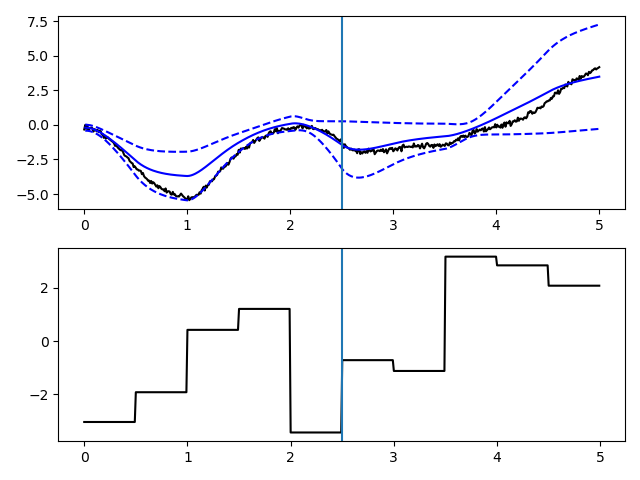

In [96]:
j = np.random.randint(n_traj)
s = 0 # observation index

fig, axs = plt.subplots(2)
# plot predicted data
axs[0].plot(np.arange(n_t)*dt, Y_data[j,:,s], 'k-')
axs[0].plot(np.arange(1,n_t)*dt, Y_pred[j,:,s], 'b-')
# 2-sigma confidence envelope
axs[0].plot(np.arange(1,n_t)*dt, Y_pred[j,:,s] + 2*np.sqrt(Sig_y_pred[j,:,s,s]), 'b--')
axs[0].plot(np.arange(1,n_t)*dt, Y_pred[j,:,s] - 2*np.sqrt(Sig_y_pred[j,:,s,s]), 'b--')
axs[0].axvline(x=n_t_train*dt, ymin=0, ymax=1)

axs[1].plot(np.arange(n_t-1)*dt, U_data[j,:,1], 'k-')
axs[1].axvline(x=n_t_train*dt, ymin=0, ymax=1)

fig.tight_layout()

# plt.savefig('figures/toy_model/EM_fit_traj_{:d}.png'.format(j), dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
# plt.savefig('figures/toy_model/EM_fit_traj_{:d}.eps'.format(j), dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
plt.show()

## Drift generator eigenvalues

<IPython.core.display.Javascript object>


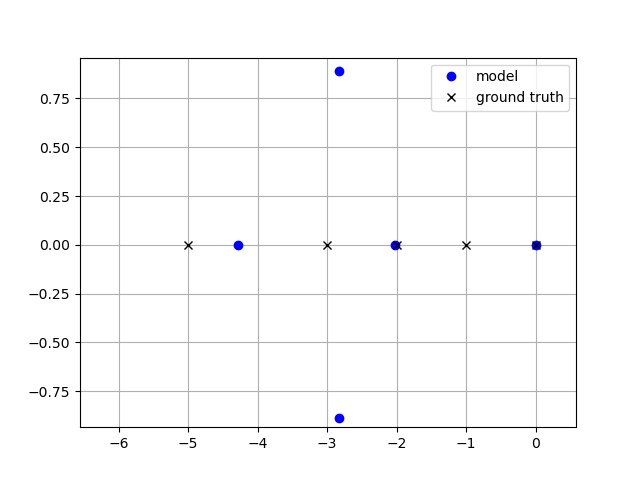

In [86]:
lam_gt = np.linalg.eigvals(V0_gt)
lam_mdl = np.linalg.eigvals(EM_model.V_matrices[0,:,:])

plt.figure()
plt.plot(np.real(lam_mdl), np.imag(lam_mdl),'bo',label='model')
plt.plot(np.real(lam_gt), np.imag(lam_gt),'kx',label='ground truth')
plt.legend()
plt.grid()

# plt.savefig('figures/toy_model/EM_model_drift_eigs.png', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
# plt.savefig('figures/toy_model/EM_model_drift_eigs.eps', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)

plt.show()